# Exercise 3.2

### **NB: This notebook was developed in Google Colab**

In [2]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
import cv2
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
torch.manual_seed(42) # for reproducibility
random.seed(42)

In [5]:
# Define the model
case = 'a'
num_classes = 10
num_epochs = 500

Changes made below include (i) removing final SoftMax because CrossEntropyLoss expects raw logits and applies log_softmax internally and (ii) using ReLU as it is generally faster to train and avoids saturation issues

In [6]:
if case == 'a':
    inputs, n_hidden0, n_hidden1, out = 784, 64, 16, 10
    ckpt_pth = 'best_model_NN.pth'
    model = nn.Sequential(
    nn.Linear(inputs, n_hidden0, bias=True),
    nn.ReLU(),
    nn.Linear(n_hidden0, n_hidden1, bias=True),
    nn.ReLU(),
    nn.Linear(n_hidden1, out, bias=True)
).to('cuda')

elif case == 'b':
    ckpt_pth = 'best_model_CNN.pth'
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to('cuda')
else:
    raise ValueError('Case choice is invalid')

model.train()

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)

In [7]:
# Load the data
with open('./drive/MyDrive/a7/0_development_data.pkl', 'rb') as f:
    devel_imgs = pickle.load(f)
train_imgs = devel_imgs[0][::2]
val_imgs = devel_imgs[0][1::2]
with open('./drive/MyDrive/a7/0_test_data.pkl', 'rb') as f:
    test_imgs = pickle.load(f)
test_imgs = test_imgs[0]

In [8]:
len(train_imgs), len(val_imgs), len(test_imgs)

(10499, 10498, 21003)

In [9]:
# Extract the labels
labels_train = [int(i[0].split('/')[-2]) for i in train_imgs]
labels_val = [int(i[0].split('/')[-2]) for i in val_imgs]
labels_test = [int(i[0].split('/')[-2]) for i in test_imgs]

Changes below include making all images grayscale, masking bottom right hand corner to remove grey squares, and shuffling data BEFORE making DataLoaders since the images are all in order (all 0s followed by all 1s etc etc)

In [ ]:
# Define the data loader and training objects
class CustomDataset(Dataset):
    def __init__(self, image_list, labels, transform=None):
        self.image_list = image_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if case == 'a':
            image = self.image_list[idx].astype(float)
            image /= 255.0 # This should be at dataset level
            image[-5:, -5:] = [0, 0, 0] # Mask 5x5 grey square in bottom-right corner
            image = image.sum(axis=2) # make grayscale
            image -= np.sum(np.sum(image,0),0) / (image.shape[0]*image.shape[1])

        elif case == 'b':
            img_tmp = self.image_list[idx]
            image = preprocess(Image.fromarray(img_tmp))
        label = self.labels[idx]
        return image, label

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
if case == 'a':
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Create CustomDataset instance
train_list = [i[1] for i in train_imgs]
val_list = [i[1] for i in val_imgs]
test_list = [i[1] for i in test_imgs]


# Shuffle training data and labels together
combined_train = list(zip(train_list, labels_train))
random.shuffle(combined_train)
train_list[:], labels_train[:] = zip(*combined_train)

# Shuffle validation data and labels together
combined_val = list(zip(val_list, labels_val))
random.shuffle(combined_val)
val_list[:], labels_val[:] = zip(*combined_val)


dataset_train = CustomDataset(train_list, labels_train, transform=None)
dataset_val = CustomDataset(val_list, labels_val, transform=None)
dataset_test = CustomDataset(test_list, labels_test, transform=None)

# Create DataLoader
batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
# Training loop
early_stopping_patience = 10

best_val_loss = 10000.0
for epoch in range(num_epochs):
    running_loss, running_val_loss = 0.0, 0.0
    model.train()
    for inputs_, labels_ in tqdm(dataloader_train):

        if case == 'a': inputs_ = torch.reshape(inputs_, (inputs_.shape[0], -1))
        inputs_, labels_ = inputs_.to(torch.float).to('cuda'), labels_.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs_)
        loss = criterion(outputs, labels_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for inputs_val, labels_val in tqdm(dataloader_val):
            if case == 'a': inputs_val = torch.reshape(inputs_val, (inputs_val.shape[0], -1))
            inputs_val, labels_val = inputs_val.to(torch.float).to('cuda'), labels_val.to('cuda')
            outputs_val = model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss/len(dataloader_val)
    if epoch_val_loss < best_val_loss:
        early_stopping_counter = 0
        best_val_loss = float(epoch_val_loss)
        torch.save(model.state_dict(), ckpt_pth)
    else:
        early_stopping_counter += 1
        if early_stopping_counter==early_stopping_patience:
            print('-------- Early Stopping ------------')
            print(f'Epoch {epoch+1}, Train loss: {running_loss/len(dataloader_train)}, Val loss: {running_val_loss/len(dataloader_val)}')
            break

    print(f'Epoch {epoch+1}, Train loss: {running_loss/len(dataloader_train)}, Val loss: {epoch_val_loss}')

100%|██████████| 329/329 [00:00<00:00, 524.87it/s]


Epoch 1, Train loss: 0.9069368404005074, Val loss: 0.4268774893870832


100%|██████████| 329/329 [00:00<00:00, 519.96it/s]


Epoch 2, Train loss: 0.35974550116977067, Val loss: 0.30929359660050787


100%|██████████| 329/329 [00:00<00:00, 513.66it/s]


Epoch 3, Train loss: 0.2833648414937015, Val loss: 0.2875588337995542


100%|██████████| 329/329 [00:00<00:00, 537.91it/s]


Epoch 4, Train loss: 0.23546804168394633, Val loss: 0.25647437845365256


100%|██████████| 329/329 [00:00<00:00, 539.37it/s]


Epoch 5, Train loss: 0.19931015695691517, Val loss: 0.24342744591388296


100%|██████████| 329/329 [00:00<00:00, 546.00it/s]


Epoch 6, Train loss: 0.17425662570131947, Val loss: 0.2187667410045092


100%|██████████| 329/329 [00:00<00:00, 544.56it/s]


Epoch 7, Train loss: 0.15345182543829944, Val loss: 0.21249939260033376


100%|██████████| 329/329 [00:00<00:00, 527.45it/s]


Epoch 8, Train loss: 0.13294289333287254, Val loss: 0.22821948290618538


100%|██████████| 329/329 [00:00<00:00, 541.04it/s]


Epoch 9, Train loss: 0.11924261435453064, Val loss: 0.2104521954296253


100%|██████████| 329/329 [00:00<00:00, 537.04it/s]


Epoch 10, Train loss: 0.10663232013673768, Val loss: 0.1960609665134848


100%|██████████| 329/329 [00:00<00:00, 499.52it/s]


Epoch 11, Train loss: 0.09416294580829361, Val loss: 0.2026152781079563


100%|██████████| 329/329 [00:00<00:00, 529.76it/s]


Epoch 12, Train loss: 0.08422806911031774, Val loss: 0.20766386585763025


100%|██████████| 329/329 [00:00<00:00, 544.46it/s]


Epoch 13, Train loss: 0.07492206269297692, Val loss: 0.20363189394396128


100%|██████████| 329/329 [00:00<00:00, 536.35it/s]


Epoch 14, Train loss: 0.06878620985043334, Val loss: 0.19472795919200978


100%|██████████| 329/329 [00:00<00:00, 531.61it/s]


Epoch 15, Train loss: 0.05485153545223539, Val loss: 0.2025640102798306


100%|██████████| 329/329 [00:00<00:00, 531.01it/s]


Epoch 16, Train loss: 0.051127704477509466, Val loss: 0.21608984788970337


100%|██████████| 329/329 [00:00<00:00, 539.14it/s]


Epoch 17, Train loss: 0.04562252141817651, Val loss: 0.22341227841366784


100%|██████████| 329/329 [00:00<00:00, 542.96it/s]


Epoch 18, Train loss: 0.04036355587883108, Val loss: 0.2087266400376227


100%|██████████| 329/329 [00:00<00:00, 540.86it/s]


Epoch 19, Train loss: 0.03566284237130854, Val loss: 0.22606469164356535


100%|██████████| 329/329 [00:00<00:00, 536.88it/s]


Epoch 20, Train loss: 0.034752466578049285, Val loss: 0.2509109049329176


100%|██████████| 329/329 [00:00<00:00, 540.61it/s]


Epoch 21, Train loss: 0.025581545513873427, Val loss: 0.22762187082322397


100%|██████████| 329/329 [00:00<00:00, 530.92it/s]


Epoch 22, Train loss: 0.02140793603060995, Val loss: 0.22417658827151352


100%|██████████| 329/329 [00:00<00:00, 523.22it/s]


Epoch 23, Train loss: 0.022158968025120684, Val loss: 0.265847882854973


100%|██████████| 329/329 [00:00<00:00, 524.63it/s]

-------- Early Stopping ------------
Epoch 24, Train loss: 0.02285792212555129, Val loss: 0.24286876947832745


In [12]:
# Make predictions on the train data
model.load_state_dict(torch.load(ckpt_pth, weights_only=True))
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)

In [13]:
# Inference function
def get_predictions(input_batch, model):

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities

In [14]:
# Run inference
preds_list = []
batch_size = 64
with torch.no_grad():
    for inputs_test, _ in tqdm(dataloader_test):
        if case == 'a': inputs_test = torch.reshape(inputs_test, (inputs_test.shape[0], -1))
        inputs_test = inputs_test.to(torch.float).to('cuda')
        preds_list.append(get_predictions(inputs_test, model).cpu().numpy())
final_preds = np.argmax(np.reshape(np.vstack(preds_list), (-1,10)),1)

100%|██████████| 657/657 [00:01<00:00, 497.91it/s]


Changes made to just display confusion matrix for further performance visualisation

In [15]:
# Generate all interesting metrics
def multiclass_metrics(y_true, y_pred, labels):
    """
    Compute per-class accuracy, sensitivity (recall), specificity, and precision.

    y_true, y_pred : array-like of shape (n_samples,)
    labels         : list of class labels, e.g. [0,1,...,9]
    """
    # Compute the full confusion matrix once
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # cm[i, j] is count of true class i predicted as class j

    # Prepare containers
    metrics = {
        "class": [],
        "accuracy": [],
        "sensitivity (recall)": [],
        "specificity": [],
        "precision": []
    }

    # Total samples
    total = cm.sum()

    for idx, cls in enumerate(labels):
        TP = cm[idx, idx]
        FN = cm[idx, :].sum() - TP
        FP = cm[:, idx].sum() - TP
        TN = total - TP - FP - FN

        # Per-class metrics
        acc = (TP + TN) / total
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0

        metrics["class"].append(cls)
        metrics["accuracy"].append(acc)
        metrics["sensitivity (recall)"].append(sens)
        metrics["specificity"].append(spec)
        metrics["precision"].append(prec)

    ConfusionMatrixDisplay(cm).plot() # display confusion matrix
    return pd.DataFrame(metrics)


,accuracy,sensitivity (recall),specificity,precision
class,,,,
0,0.993477,0.973379,0.995670,0.960822
1,0.993572,0.973100,0.996142,0.969375
2,0.989287,0.929631,0.995876,0.961386
3,0.985954,0.925551,0.992936,0.938053
4,0.989287,0.954322,0.993041,0.936386
5,0.986764,0.928346,0.992567,0.925420
6,0.993191,0.953601,0.997518,0.976733
7,0.989382,0.956838,0.993192,0.942704
8,0.985954,0.939961,0.990881,0.916947


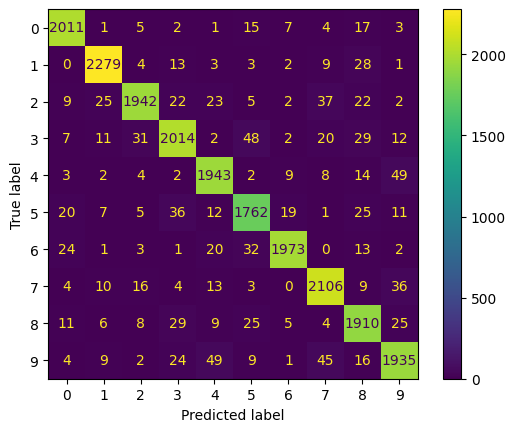

In [16]:
# Report the performance
report_df = multiclass_metrics(labels_test, final_preds, np.arange(10).tolist()).set_index('class')
report_df